In [1]:
from chess import Board, Move, ROOK, BISHOP, KNIGHT, QUEEN, PAWN, KING, WHITE, BLACK
import pandas as pd
import numpy as np
import re, itertools, os, time, math

from collections import OrderedDict, Counter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0")

In [2]:
DATA_DIR = 'data/'
ELO_CUTOFF = 2400
MAX_MOVES = 150
PROCESSED_FNAME = DATA_DIR + 'permove_data.csv'
MODEL_PATH = 'models/chessnet.sd'
if not os.path.exists('models'):
    os.mkdir('models')

In [3]:
cvc_df = pd.read_csv(DATA_DIR + '2016_CvC.csv')
cvh_df = pd.read_csv(DATA_DIR + '2016_CvH.csv')
df = pd.concat([cvc_df, cvh_df])
df.columns = [c.lower().replace(' ', '_') for c in df.columns]

In [4]:
df.shape

(129912, 20)

In [5]:
df.head()

,game,white,black,white_elo,black_elo,white_rd,black_rd,whiteiscomp,blackiscomp,timecontrol,date,time,white_clock,black_clock,eco,plycount,result,result-winner,commentaries,moves
0,"""zerowin"" vs ""GeidiPrime""",zerowin,GeidiPrime,2848,2464,0.0,0.0,Yes,Yes,900+0,2016.12.31,23:17:00,15:00.0,15:00.0,A30,72,1/2-1/2,Draw,Game drawn by mutual agreement,1. c4 c5 2. Nf3 e6 3. g3 b6 4. Bg2 Bb7 5. O-O ...
1,"""GeidiPrime"" vs ""SlowBox""",GeidiPrime,SlowBox,2455,2511,0.0,0.0,Yes,Yes,900+0,2016.12.31,20:25:00,15:00.0,15:00.0,D01,127,1-0,White,Black checkmated,1. d4 Nf6 2. Nc3 d5 3. Bg5 Nbd7 4. Nf3 h6 5. B...
2,"""zerowin"" vs ""GeidiPrime""",zerowin,GeidiPrime,2846,2457,0.0,0.0,Yes,Yes,900+0,2016.12.31,20:03:00,15:00.0,15:00.0,A40,77,1-0,White,Black resigns,1. d4 e6 2. c4 Bb4+ 3. Bd2 Bxd2+ 4. Qxd2 Nf6 5...
3,"""GeidiPrime"" vs ""zerowin""",GeidiPrime,zerowin,2459,2844,0.0,0.0,Yes,Yes,900+0,2016.12.31,19:25:00,15:00.0,15:00.0,C11,128,0-1,Black,White resigns,1. d4 Nf6 2. Nc3 d5 3. Bg5 e6 4. e4 dxe4 5. Nx...
4,"""FishTest"" vs ""GeidiPrime""",FishTest,GeidiPrime,3033,2459,0.0,0.0,Yes,Yes,900+0,2016.12.31,18:42:00,15:00.0,15:00.0,C07,131,1-0,White,Black resigns,1. e4 e6 2. d4 d5 3. Nd2 c5 4. exd5 Qxd5 5. dx...


In [6]:
df[df.plycount <= MAX_MOVES].plycount

0         72
1        127
2         77
3        128
4        131
5         91
6        138
7        134
8        115
9         62
11       131
12       150
13        43
14       101
18       147
19       138
21       127
22        89
24       150
25       105
26       140
27        67
28       111
29       108
30        12
32        54
36       133
37       119
38        91
39         0
        ... 
81011     63
81012     75
81013    114
81014    132
81015     51
81016     27
81017     25
81018     23
81019     26
81020     59
81021     39
81022     94
81023     59
81024     33
81025     27
81026     26
81027     11
81028    113
81029      6
81030     47
81031     13
81032     36
81033     50
81034     39
81035     73
81036     54
81037     17
81038     36
81039     73
81040     41
Name: plycount, Length: 114186, dtype: int64

In [7]:
df = df[(df['commentaries'].str.contains('disconnected')==False) &
        (df['white_elo'] > ELO_CUTOFF) &
        (df['black_elo'] > ELO_CUTOFF) &
        (df['plycount'] <= MAX_MOVES)]

In [8]:
df.shape

(19564, 20)

In [9]:
set(df.result)

{' 1-0', '0-1', '1/2-1/2'}

In [10]:
WHITE_WIN = ' 1-0' # Note the space LOL. This took way too long to debug.
BLACK_WIN = '0-1'
TIE = '1/2-1/2'

In [11]:
{r: len(df[df.result == r]) for r in (WHITE_WIN, BLACK_WIN, TIE)}

{' 1-0': 8799, '0-1': 6913, '1/2-1/2': 3852}

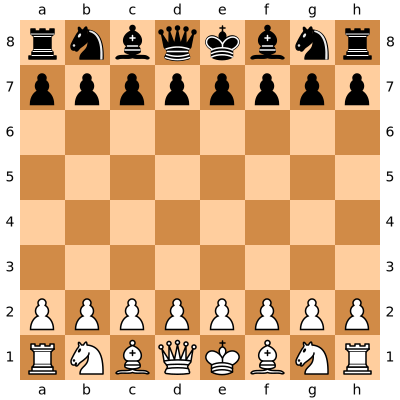

In [12]:
b = Board()
b

In [13]:
dir(b)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algebraic',
 '_attacked_for_king',
 '_attackers_mask',
 '_castling_uncovers_rank_attack',
 '_clear_board',
 '_ep_skewered',
 '_epd_operations',
 '_from_chess960',
 '_generate_evasions',
 '_is_safe',
 '_parse_epd_ops',
 '_push_capture',
 '_remove_piece_at',
 '_repr_svg_',
 '_reset_board',
 '_set_board_fen',
 '_set_castling_fen',
 '_set_chess960_pos',
 '_set_piece_at',
 '_set_piece_map',
 '_slider_blockers',
 '_to_chess960',
 '_transposition_key',
 '_valid_ep_square',
 'aliases',
 'apply_transform',
 'attackers',
 'attackers_mask',
 'attacks',
 'attacks_mask',
 'bishops',
 'board_fen',
 'can_

In [14]:
b.fen()

'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'

In [15]:
openingb  = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
# Lots of promotions possible
longtimeb = 'R3K2R/PPPPPPPP/8/8/8/8/pppppppp/4k3 w KQkq - 0 1'
b2 = Board(longtimeb)
for m in b2.legal_moves:
    print(m, 'promo', m.promotion, 'drop', m.drop)

h8g8 promo None drop None
h8f8 promo None drop None
e8f8 promo None drop None
e8d8 promo None drop None
a8d8 promo None drop None
a8c8 promo None drop None
a8b8 promo None drop None
g7g8q promo 5 drop None
g7g8r promo 4 drop None
g7g8b promo 3 drop None
g7g8n promo 2 drop None
f7f8q promo 5 drop None
f7f8r promo 4 drop None
f7f8b promo 3 drop None
f7f8n promo 2 drop None
d7d8q promo 5 drop None
d7d8r promo 4 drop None
d7d8b promo 3 drop None
d7d8n promo 2 drop None
c7c8q promo 5 drop None
c7c8r promo 4 drop None
c7c8b promo 3 drop None
c7c8n promo 2 drop None
b7b8q promo 5 drop None
b7b8r promo 4 drop None
b7b8b promo 3 drop None
b7b8n promo 2 drop None


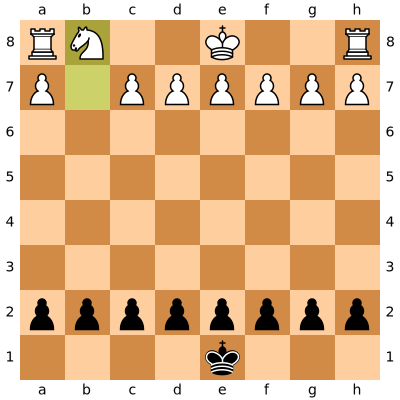

In [16]:
b2.push(list(b2.legal_moves)[-1])
b2

In [17]:
#    +
#    N
# -W   E+
#    S
#    -
DIRECTIONS = ['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
WHITE_DIRS, BLACK_DIRS = ['NW', 'N', 'NE'], ['SE', 'S', 'SW'] # Pawn directions
UNDER_PROMOS = [ROOK, BISHOP, KNIGHT]
def deltas2dir(dx, dy):
    if dx > 0 and dy == 0:
        return 'E'
    elif dx > 0 and dy > 0:
        return 'NE'
    elif dx == 0 and dy > 0:
        return 'N'
    elif dx < 0 and dy > 0:
        return 'NW'
    elif dx < 0 and dy == 0:
        return 'W'
    elif dx < 0 and dy < 0:
        return 'SW'
    elif dx == 0 and dy < 0:
        return 'S'
    elif dx > 0 and dy < 0:
        return 'SE'
    else:
        raise ValueError('dx and dy cannot both be 0')


# Since our NN will output an 73x8x8 policy vector we will use these to translate 
# between NN and Board interpretation of a move
def move2idx(move):
    x, y = move.from_square % 8, move.from_square // 8
    dx, dy = move.to_square % 8 - x, move.to_square // 8 - y
    distance, direction = max(abs(dx), abs(dy)), deltas2dir(dx, dy)
    if move.promotion in UNDER_PROMOS: # Pawn underpromotion
        assert y in (6, 1)
        z = UNDER_PROMOS.index(move.promotion) * 3 + 64 + \
            (WHITE_DIRS if y == 6 else BLACK_DIRS).index(direction)
    elif {abs(dx), abs(dy)} == {1, 2}: # Knight move
        z = ((abs(dx) == 2) << 2) & ((dx > 0) << 1) & (dy > 0) + 56
    else: # Queen move or promo to Queen
        z = DIRECTIONS.index(direction) * 7 + distance - 1
    return x, y, z

xy2uci = lambda x, y: 'abcdefgh'[x] + str(y+1)

def idx2move(board, x, y, z):
    if z < 56: # Queen move or promo to Queen
        distance = z % 7 + 1
        direction = DIRECTIONS[z // 7]
        dx = distance * (-1 if 'W' in direction else 1 if 'E' in direction else 0)
        dy = distance * (-1 if 'S' in direction else 1 if 'N' in direction else 0)
        print('promo queen?', (x, y), x+y*8, board.piece_at(x + y * 8).piece_type, y+dy)
        promo = 'q' if board.piece_at(x + y * 8).piece_type == PAWN and (y + dy in (0, 7)) else ''
    elif z < 64: # Knight move
        z -= 56
        dx = 2 if ((z >> 2) & 1) else 1
        dy = 2 if dx == 1 else 1
        dx *= 1 if ((z >> 1) & 1) else -1
        dy *= 1 if ((z >> 0) & 1) else -1
        promo = ''
    elif z < 73: # Pawn underpromotion
        assert y in (6, 1)
        z -= 64
        direction = (WHITE_DIRS if y == 6 else BLACK_DIRS)[z % 3]
        promo = UNDER_PROMOS[z // 3]
        promo = 'r' if promo == ROOK else 'n' if promo == KNIGHT else 'b'
        dx = -1 if 'W' in direction else 1 if 'E' in direction else 0
        dy = -1 if 'S' in direction else 1 if 'N' in direction else 0
    else: # WTF
        raise ValueError('Invalid z >= 73. z = %d.' % z)

    return Move.from_uci(xy2uci(x, y) + xy2uci(x+dx, y+dy) + promo)


In [18]:
piece2plane = {val: idx for idx, val in enumerate([
    (WHITE, PAWN),
    (WHITE, ROOK),
    (WHITE, KNIGHT),
    (WHITE, BISHOP),
    (WHITE, QUEEN),
    (WHITE, KING),
    (BLACK, PAWN),
    (BLACK, ROOK),
    (BLACK, KNIGHT),
    (BLACK, BISHOP),
    (BLACK, QUEEN),
    (BLACK, KING),
    (WHITE, 'has_kingside_castling_rights'),
    (WHITE, 'has_queenside_castling_rights'),
    (BLACK, 'has_kingside_castling_rights'),
    (BLACK, 'has_queenside_castling_rights'),
    'turn'
])}

def board2tensor(board):
    tensor = torch.zeros([len(piece2plane), 8, 8], dtype=torch.float32)
    
    # 12 Planes for each piece/color combination
    for x, y in itertools.product(range(8), range(8)):
        sqr = x + y*8
        piece = board.piece_at(sqr)
        if not piece: continue
        plane = piece2plane[(piece.color, piece.piece_type)]
        tensor[plane][x][y] = 1
    
    # 4 planes for castling rights
    combinations = itertools.product((WHITE, BLACK), (board.has_queenside_castling_rights, board.has_kingside_castling_rights))
    for color, func in combinations:
        if func(color):
            plane = piece2plane[(color, func.__name__)]
            tensor[plane,:,:] = 1
    
    # 1 plane is 1 if it is BLACK's turn to move, else 0 if WHITE's turn
    if board.turn == BLACK:
        plane = piece2plane['turn']
        tensor[plane,:,:] = 1
    
    return tensor


def state2policy(board, best_move_idx):
    tensor = torch.zeros([73, 8, 8], dtype=torch.float32)
#     for x, y, z in (move2idx(m) for m in board.legal_moves):
#         tensor[z][x][y] = 1
    
    x, y, z = best_move_idx
    tensor[z][x][y] = 1               # Make the best move worth more
    return tensor / torch.sum(tensor) # Turn tensor into probabilities (sum(tensor) == 1)


state_data, value_data, move_data = [], [], []
for i, (result, moves) in enumerate(zip(df.result, df.moves)): # This could use some multiprocessing
    if i % 100 == 0:
        print('{0:.2f}%'.format(i / df.shape[0] * 100.0), end='\r')
    result = result.strip()
    moves = sum([m.strip().split() for m in re.split(r'[0-9]+\. ', moves) if m], [])
    # value of state from player's perspective 
    # 1 from winner's perspective, -1 from loser's perspective, 0 if tie
    value = 1 if result == WHITE_WIN else -1 if result == BLACK_WIN else 0
    board = Board()
    for move_str in moves:
        move = board.parse_san(move_str)

        # Store data point
        state_data.append(board.fen())
        value_data.append(value)
        move_data.append(move_str)

        # Move to next data point
        board.push(move)

        value *= -1
print('Done')
permove_df = pd.DataFrame(data={'state': state_data, 'value': value_data, 'move': move_data})

# Make even number of win/loss/tie
res2count = {r: len(permove_df[permove_df.value == r]) for r in (-1, 1, 0)}
print(res2count)
least = min(res2count.values())
rows, counts = [], {-1:0, 0:0, 1:0}
for state, value, move in zip(permove_df.state, permove_df.value, permove_df.move):
    if counts[value] >= least: continue
    counts[value] += 1
    rows.append([state, value, move])

permove_df = pd.DataFrame(rows, columns=['state', 'value', 'move'])
del rows
print({r: len(permove_df[permove_df.value == r]) for r in (-1, 1, 0)})


permove_df.to_csv(PROCESSED_FNAME)

In [ ]:
permove_df = pd.read_csv(PROCESSED_FNAME)

In [ ]:
permove_df.head()

,Unnamed: 0,state,value,move
0,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,0,c4
1,1,rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR ...,0,c5
2,2,rnbqkbnr/pp1ppppp/8/2p5/2P5/8/PP1PPPPP/RNBQKBN...,0,Nf3
3,3,rnbqkbnr/pp1ppppp/8/2p5/2P5/5N2/PP1PPPPP/RNBQK...,0,e6
4,4,rnbqkbnr/pp1p1ppp/4p3/2p5/2P5/5N2/PP1PPPPP/RNB...,0,g3


In [ ]:
n_rows = permove_df.shape[0]
print(n_rows)

1091007


In [ ]:
permove_df.head()

,Unnamed: 0,state,value,move
0,0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,0,c4
1,1,rnbqkbnr/pppppppp/8/8/2P5/8/PP1PPPPP/RNBQKBNR ...,0,c5
2,2,rnbqkbnr/pp1ppppp/8/2p5/2P5/8/PP1PPPPP/RNBQKBN...,0,Nf3
3,3,rnbqkbnr/pp1ppppp/8/2p5/2P5/5N2/PP1PPPPP/RNBQK...,0,e6
4,4,rnbqkbnr/pp1p1ppp/4p3/2p5/2P5/5N2/PP1PPPPP/RNB...,0,g3


In [ ]:
class SupervisedChessDataset(Dataset):
    
    def __init__(self, df, idxs):
        self.df = df.iloc[idxs]
        self.length = self.df.shape[0]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx,:]
        state, value, move = row.state, row.value, row.move
        board = Board(state)
        move_idxs = move2idx(board.parse_san(move))
        return {'state': board2tensor(board),
                'value': torch.FloatTensor([value]), # Do we need to convert to Tensor?
                'policy': state2policy(board, move_idxs)
               }

In [ ]:
class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.net = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 256, 3, padding=1)),
            ('batchnorm1', nn.BatchNorm2d(256)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(256, 256, 3, padding=1)),
            ('batchnorm1', nn.BatchNorm2d(256)),
        ]))
        self.relu_out = nn.ReLU(inplace=True)
        
    def forward(self, x):
        conv_out = self.net(x)
        return self.relu_out(conv_out + x)

    
class Flatten(nn.Module):
    def forward(self, x):
        return x.flatten(1)

    
class ChessNet(nn.Module):
    def __init__(self, n_res_blocks=19, learning_rate=0.01, bias=False, gpu_id=0):
        super(ChessNet, self).__init__()
        res_blocks = [(f'res_block{i+1}', ResBlock()) for i in range(n_res_blocks)]
        self.res_tower = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(len(piece2plane), 256, 3, padding=1)),
            ('batchnorm1', nn.BatchNorm2d(256)),
            ('relu1', nn.ReLU(inplace=True)),
            *res_blocks
        ]))
        self.policy_head = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 2, 1)),
            ('batchnorm1', nn.BatchNorm2d(2)),
            ('relu1', nn.ReLU(inplace=True)),
            ('flatten', Flatten()),
            ('fc1', nn.Linear(8*8*2, 8*8*73)),
            ('softmax', nn.Softmax(dim=1))
        ]))
        self.value_head = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(256, 1, 1)),
            ('batchnorm1', nn.BatchNorm2d(1)),
            ('relu1', nn.ReLU(inplace=True)),
            ('flatten', Flatten()), # Should we flatten here or after? Does it matter?
            ('fc1', nn.Linear(64, 256)),
            ('relu2', nn.ReLU(inplace=True)),
            ('fc2', nn.Linear(256, 1)),
            ('tanh', nn.Tanh())
        ]))
        
    def forward(self, x):
        tower_out = self.res_tower(x)
        policy_out = self.policy_head(tower_out)
        value_out = self.value_head(tower_out)
        
        return policy_out.view(-1, 73, 8, 8), value_out.view(-1, 1)

In [ ]:
nnet = ChessNet(n_res_blocks=19)
nnet.to(device)
if os.path.exists(MODEL_PATH):
    nnet.load_state_dict(torch.load(MODEL_PATH))
else:
    def init_weights(m):
        if type(m) == nn.Linear:
            stdv = .1 / math.sqrt(m.weight.size(1))
            m.weight.data.uniform_(-stdv, stdv)
            if m.bias is not None:
                m.bias.data.uniform_(-stdv, stdv)
    nnet.value_head.apply(init_weights)

data = train_ds[0]
state, policy, value = data['state'].to(device), data['policy'].to(device), data['value'].to(device)
x = state.unsqueeze(0)
policy, value = nnet.forward(x)
print(x.size(), '->', (policy.size(), value.size()))

In [ ]:
BATCH_SIZE = 16
np.random.seed(42)
idxs = np.arange(n_rows)
np.random.shuffle(idxs)
train, val, test = idxs[:n_rows*8//10], idxs[n_rows*8//10:n_rows*9//10], idxs[n_rows*9//10:]
print((len(train), len(val), len(test)))
train_ds, val_ds, test_ds = [SupervisedChessDataset(permove_df, idxs)
                             for idxs in [train, val, test]]
train_dl, val_dl, test_dl = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
                             for ds in [train_ds, val_ds, test_ds]]

(872805, 109101, 109101)


In [ ]:
EPOCHS = 10
policy_criterion = nn.BCELoss()
value_criterion = nn.MSELoss()
MSE_WEIGHT = 0.015
BCE_WEIGHT = 2.
UPDATE_FREQ = 10 # in number of batches
NL_UPDATE_FREQ = 2000

optimizer = optim.SGD(nnet.parameters(), lr=0.2, momentum=0.9, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200000, 400000, 600000, 700000], gamma=0.1)

best_loss = float('inf')
scheduler.get_lr(), best_loss

([0.2], inf)

In [ ]:
for epoch in range(EPOCHS):    
    running_policy_loss, running_value_loss, value_counter, t0 = 0.0, 0.0, Counter(), time.time()
    nnet.train()
    for i, batch in enumerate(train_dl):
        # Transfer to GPU
        state, policy, value = batch['state'].to(device), batch['policy'].to(device), batch['value'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        policy_out, value_out = nnet(state)
        policy_loss = policy_criterion(policy_out, policy) * BCE_WEIGHT
        value_loss  = value_criterion(value_out, value) * MSE_WEIGHT
        total_loss = policy_loss + value_loss
        total_loss.backward()
        optimizer.step()

        # print statistics
        running_policy_loss += policy_loss.item()
        running_value_loss  += value_loss.item()
        value_counter.update((round(v.item()) for v in value_out))
        denom = i % NL_UPDATE_FREQ + 1
        if i % UPDATE_FREQ == UPDATE_FREQ - 1:    # print every UPDATE_FREQ mini-batches
            print('[%d,%7d] (%6.2fs) policy_loss: %.4e value_loss: %.4e total_loss: %.4e lr: %.2e %s                  ' %
                  (epoch + 1, i + 1, time.time() - t0, running_policy_loss / denom, running_value_loss / denom,
                   (running_policy_loss + running_value_loss) / denom, scheduler.get_lr()[0], str(value_counter)), end='\n' if denom == NL_UPDATE_FREQ else '\r')
        
        if denom == NL_UPDATE_FREQ:
            running_policy_loss, running_value_loss, value_counter, t0 = 0.0, 0.0, Counter(), time.time()
        
        scheduler.step()


    # Validation
    nnet.eval()
    correct, total, value_loss_total, policy_loss_total = 0, 0, 0.0, 0.0
    with torch.set_grad_enabled(False):
        for i, batch in enumerate(val_dl):
            # Transfer to GPU
            state, policy, value = batch['state'].to(device), batch['policy'].to(device), batch['value'].to(device)
            policy_out, value_out = nnet(state)
            policy_loss = policy_criterion(policy_out, policy) * BCE_WEIGHT
            value_loss  = value_criterion(value_out, value) * MSE_WEIGHT

            correct += sum(policy.flatten(1).argmax(1) == policy_out.flatten(1).argmax(1)).item()
            total += policy.size()[0]
            value_loss_total += value_loss.item()
            policy_loss_total += policy_loss.item()
            
    acc = correct/total
    avg_value_loss = value_loss_total/len(val_dl)
    avg_policy_loss = policy_loss_total/len(val_dl)
    avg_loss = avg_value_loss + avg_policy_loss
    print(f'VALIDATION RESULTS: accuracy: {acc*100:.3f}%, total loss: {avg_loss:.3e}, policy loss: {avg_policy_loss:.3e}, value_loss: {avg_value_loss:.3e}')
    if avg_loss < best_loss:
        print("Saving model!")
        best_loss = avg_loss
        torch.save(nnet.state_dict(), MODEL_PATH)

[1,   2000] ( 65.26s) policy_loss: 4.0305e-03 value_loss: 3.5707e-03 total_loss: 7.6012e-03 lr: 2.00e-01 Counter({-1: 15162, 1: 14918, 0: 1920})                  
[1,   4000] ( 64.53s) policy_loss: 3.9578e-03 value_loss: 3.3755e-03 total_loss: 7.3333e-03 lr: 2.00e-01 Counter({-1: 16067, 1: 15340, 0: 593})                  
[1,   6000] ( 64.23s) policy_loss: 3.8030e-03 value_loss: 3.3407e-03 total_loss: 7.1438e-03 lr: 2.00e-01 Counter({-1: 16138, 1: 15146, 0: 716})                  
[1,   8000] ( 63.36s) policy_loss: 3.6474e-03 value_loss: 3.3322e-03 total_loss: 6.9797e-03 lr: 2.00e-01 Counter({-1: 15999, 1: 15155, 0: 846})                  
[1,  10000] ( 64.59s) policy_loss: 3.4933e-03 value_loss: 3.3398e-03 total_loss: 6.8331e-03 lr: 2.00e-01 Counter({-1: 15933, 1: 15214, 0: 853})                  
[1,  12000] ( 64.21s) policy_loss: 3.3626e-03 value_loss: 3.3225e-03 total_loss: 6.6851e-03 lr: 2.00e-01 Counter({-1: 15916, 1: 15270, 0: 814})                  
[1,  14000] ( 64.41s) polic